In [10]:
import pandas as pd
import numpy as np
import sys
import mne
from datetime import datetime
sys.path.append('/Users/rufaelmarew/Documents/tau/finger_pose_estimation')
from util import read_emg

### Read and preprocess Leap Data

In [11]:
#  variables
joints = ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']
fingers = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']

In [12]:
data_path = "/Users/rufaelmarew/Documents/tau/finger_pose_estimation/dataset/FPE/S1/p3/fpe_pos3_001_S1_rep0_BT.csv"
leap_data = pd.read_csv(data_path, index_col=0)

# drop null and duplicates
leap_data.dropna(inplace=True)
leap_data.drop_duplicates(inplace=True, subset=['time'])

# convert to datetime
leap_data['time'] = pd.to_datetime(leap_data['time'], utc=True)
leap_data.set_index('time', inplace=True)
leap_data.head()

,timestamp,hand_id,hand_type,palm_x,palm_y,palm_z,Thumb_Metacarpal_position_x,Thumb_Metacarpal_position_y,Thumb_Metacarpal_position_z,Thumb_Metacarpal_rotation_x,...,Pinky_Intermediate_rotation_y,Pinky_Intermediate_rotation_z,Pinky_Intermediate_rotation_w,Pinky_Distal_position_x,Pinky_Distal_position_y,Pinky_Distal_position_z,Pinky_Distal_rotation_x,Pinky_Distal_rotation_y,Pinky_Distal_rotation_z,Pinky_Distal_rotation_w
time,,,,,,,,,,,,,,,,,,,,,
2024-01-02 11:17:50.144476+00:00,618129404397,501.0,right,26.505798,314.682159,21.602861,19.519218,305.717377,65.277779,0.251093,...,0.114867,-0.153174,0.536789,46.999077,296.593964,-0.170629,0.948709,-0.198444,0.155252,-0.190964
2024-01-02 11:17:50.145478+00:00,618129433911,501.0,right,28.034868,318.359802,22.881432,20.635479,308.574280,66.270164,0.263341,...,-0.139723,0.090655,-0.291937,44.050884,292.290466,16.530960,0.984230,-0.158460,0.016264,0.076930
2024-01-02 11:17:50.156983+00:00,618129445007,501.0,right,28.292986,319.191345,22.858692,20.754112,309.309631,66.215508,0.265803,...,-0.146146,0.090773,-0.291130,43.842854,292.761597,16.763844,0.983030,-0.164565,0.013571,0.079911
2024-01-02 11:17:50.168008+00:00,618129456271,501.0,right,28.412083,319.694641,22.847219,20.729889,309.738708,66.170441,0.267137,...,-0.147527,0.091272,-0.289848,43.774654,293.106812,16.948614,0.982670,-0.165996,0.013236,0.081427
2024-01-02 11:17:50.179519+00:00,618129467376,501.0,right,28.472631,320.013092,22.824993,20.673723,310.016907,66.134026,0.268122,...,-0.151638,0.091944,-0.288945,43.592751,293.296143,17.039610,0.981882,-0.170083,0.012182,0.082655


In [13]:
# calculate relative position
for i in leap_data.columns:

    if 'position_x' in i:
        leap_data[i] = leap_data[i] - leap_data['palm_x']
    elif 'position_y' in i:
        leap_data[i] = leap_data[i] - leap_data['palm_y']
    elif 'position_z' in i:
        leap_data[i] = leap_data[i] - leap_data['palm_z']
    else:
        continue
leap_data.head()

,timestamp,hand_id,hand_type,palm_x,palm_y,palm_z,Thumb_Metacarpal_position_x,Thumb_Metacarpal_position_y,Thumb_Metacarpal_position_z,Thumb_Metacarpal_rotation_x,...,Pinky_Intermediate_rotation_y,Pinky_Intermediate_rotation_z,Pinky_Intermediate_rotation_w,Pinky_Distal_position_x,Pinky_Distal_position_y,Pinky_Distal_position_z,Pinky_Distal_rotation_x,Pinky_Distal_rotation_y,Pinky_Distal_rotation_z,Pinky_Distal_rotation_w
time,,,,,,,,,,,,,,,,,,,,,
2024-01-02 11:17:50.144476+00:00,618129404397,501.0,right,26.505798,314.682159,21.602861,-6.986580,-8.964783,43.674917,0.251093,...,0.114867,-0.153174,0.536789,20.493279,-18.088196,-21.773490,0.948709,-0.198444,0.155252,-0.190964
2024-01-02 11:17:50.145478+00:00,618129433911,501.0,right,28.034868,318.359802,22.881432,-7.399389,-9.785522,43.388733,0.263341,...,-0.139723,0.090655,-0.291937,16.016016,-26.069336,-6.350471,0.984230,-0.158460,0.016264,0.076930
2024-01-02 11:17:50.156983+00:00,618129445007,501.0,right,28.292986,319.191345,22.858692,-7.538874,-9.881714,43.356815,0.265803,...,-0.146146,0.090773,-0.291130,15.549868,-26.429749,-6.094849,0.983030,-0.164565,0.013571,0.079911
2024-01-02 11:17:50.168008+00:00,618129456271,501.0,right,28.412083,319.694641,22.847219,-7.682194,-9.955933,43.323221,0.267137,...,-0.147527,0.091272,-0.289848,15.362572,-26.587830,-5.898605,0.982670,-0.165996,0.013236,0.081427
2024-01-02 11:17:50.179519+00:00,618129467376,501.0,right,28.472631,320.013092,22.824993,-7.798908,-9.996185,43.309032,0.268122,...,-0.151638,0.091944,-0.288945,15.120119,-26.716949,-5.785383,0.981882,-0.170083,0.012182,0.082655


In [14]:
resampled_leap_data = leap_data.resample('8ms').ffill()

In [15]:
#  check effect of resampling on the data
from matplotlib import pyplot as plt
numerical_columns = [i for i in resampled_leap_data.columns if 'position' in i or 'rotation' in i]
# for i in numerical_columns:
#     leap_data[i].plot()
#     resampled_leap_data[i].plot()
#     plt.legend(['original', 'resampled'])
#     plt.title(i)
#     plt.show()
original_mean = leap_data[numerical_columns].mean()
original_median = leap_data[numerical_columns].median()
original_std = leap_data[numerical_columns].std()

resampled_mean = resampled_leap_data[numerical_columns].mean()
resampled_median = resampled_leap_data[numerical_columns].median()
resampled_std = resampled_leap_data[numerical_columns].std()

print(f'original mean: {original_mean.mean()} \n resampled mean: {resampled_mean.mean()} \n')
print(f'original median: {original_median.mean()} \n resampled median: {resampled_median.mean()} \n')
print(f'original std: {original_std.mean()} \n resampled std: {resampled_std.mean()} \n')
print(f'original end time: {leap_data.index[-1]} \n resampled end time: {resampled_leap_data.index[-1]} \n')

original mean: -1.4937110355284284 
 resampled mean: -1.488312592535347 

original median: -1.586071747075767 
 resampled median: -1.5908070409703745 

original std: 2.8857724761755663 
 resampled std: 2.8936935269559836 

original end time: 2024-01-02 11:26:25.371403+00:00 
 resampled end time: 2024-01-02 11:26:25.368000+00:00 



In [16]:
#  duration in seconds
duration = (leap_data.index[-1] - leap_data.index[0]).total_seconds()
num_smaples = len(leap_data)

print(f'frequncy: {num_smaples/duration} Hz')
print(f'num samples: {num_smaples}')

frequncy: 88.78612045057186 Hz
num samples: 45745


In [17]:
# duration of resampled data
duration = (resampled_leap_data.index[-1] - resampled_leap_data.index[0]).total_seconds()
num_smaples = len(resampled_leap_data)

print(f'frequncy: {num_smaples/duration} Hz')
print(f'num samples: {num_smaples}')

frequncy: 125.00194090337405 Hz
num samples: 64404


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

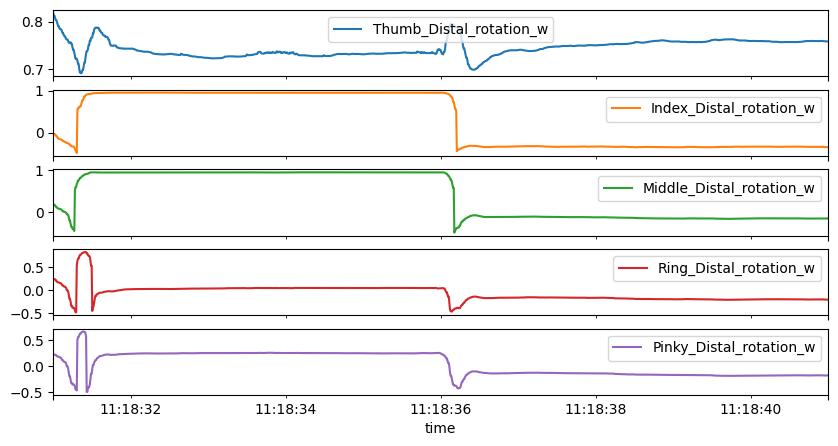

In [344]:
joints = ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']
fingers = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
# plot the time series data starting from start time for 5 seconds
start_time = pd.to_datetime(datetime(2024, 1, 2, 11, 18, 31), utc=True)
end_time = start_time + pd.Timedelta(seconds=10)
# cols = [f'Index_{i}_rotation_w' for i in joints]
cols = [f'{i}_Distal_rotation_w' for i in fingers]
resampled_leap_data.loc[start_time:end_time][cols].plot(subplots=True, figsize=(10, 5))


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

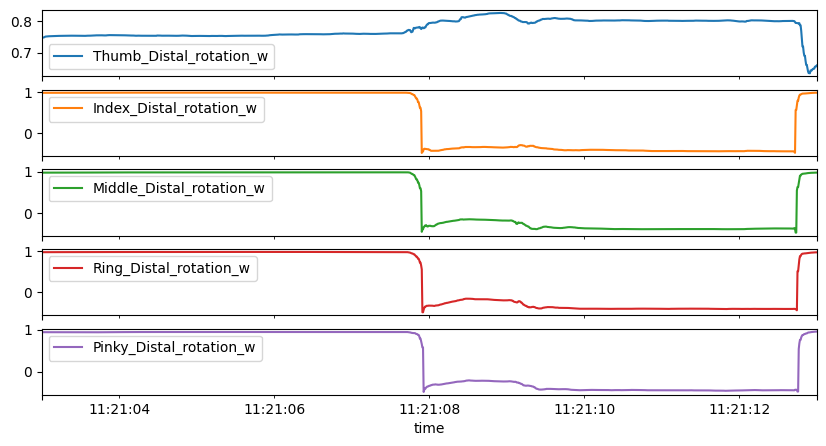

In [330]:


# plot the time series data starting from start time for 5 seconds
start_time = pd.to_datetime(datetime(2024, 1, 2, 11, 21, 3), utc=True)
end_time = start_time + pd.Timedelta(seconds=10)
# cols = [f'Pinky_{i}_rotation_w' for i in joints]
cols = [f'{i}_Distal_rotation_w' for i in fingers]
resampled_leap_data.loc[start_time:end_time][cols].plot(subplots=True, figsize=(10, 5))

In [345]:
resampled_leap_data.head()

,timestamp,hand_id,hand_type,palm_x,palm_y,palm_z,Thumb_Metacarpal_position_x,Thumb_Metacarpal_position_y,Thumb_Metacarpal_position_z,Thumb_Metacarpal_rotation_x,...,Pinky_Intermediate_rotation_y,Pinky_Intermediate_rotation_z,Pinky_Intermediate_rotation_w,Pinky_Distal_position_x,Pinky_Distal_position_y,Pinky_Distal_position_z,Pinky_Distal_rotation_x,Pinky_Distal_rotation_y,Pinky_Distal_rotation_z,Pinky_Distal_rotation_w
time,,,,,,,,,,,,,,,,,,,,,
2024-01-02 11:17:50.144000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-02 11:17:50.152000+00:00,6.181294e+11,501.0,right,28.034868,318.359802,22.881432,-35.434258,-328.145325,20.507301,0.263341,...,-0.139723,0.090655,-0.291937,-12.018852,-344.429138,-29.231903,0.98423,-0.158460,0.016264,0.076930
2024-01-02 11:17:50.160000+00:00,6.181294e+11,501.0,right,28.292986,319.191345,22.858692,-35.831860,-329.073059,20.498123,0.265803,...,-0.146146,0.090773,-0.291130,-12.743118,-345.621094,-28.953541,0.98303,-0.164565,0.013571,0.079911
2024-01-02 11:17:50.168000+00:00,6.181294e+11,501.0,right,28.292986,319.191345,22.858692,-35.831860,-329.073059,20.498123,0.265803,...,-0.146146,0.090773,-0.291130,-12.743118,-345.621094,-28.953541,0.98303,-0.164565,0.013571,0.079911
2024-01-02 11:17:50.176000+00:00,6.181295e+11,501.0,right,28.412083,319.694641,22.847219,-36.094276,-329.650574,20.476002,0.267137,...,-0.147527,0.091272,-0.289848,-13.049511,-346.282471,-28.745825,0.98267,-0.165996,0.013236,0.081427


#### Read and preprocess EMG data

In [18]:
emg_path = "/Users/rufaelmarew/Documents/tau/finger_pose_estimation/dataset/FPE/S1/p3/fpe_pos3_001_S1_rep0_BT.edf"
raw = mne.io.read_raw_edf(emg_path, preload=True)
header = raw.info
annotaions = raw.annotations
emg_data = raw.to_data_frame()
print(header)

emg_data['time'] = pd.to_datetime(emg_data['time'], unit='s', utc=True, origin=datetime(2024,1,2, 11,17,25))
emg_data.set_index('time', inplace=True)
# emg_data.resample('8ms').ffill()
emg_data.head()

Extracting EDF parameters from /Users/rufaelmarew/Documents/tau/finger_pose_estimation/dataset/FPE/S1/p3/fpe_pos3_001_S1_rep0_BT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 135499  =      0.000 ...   541.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Channel 0, Channel 1, Channel 2, Channel 3, Channel 4, Channel ...
 chs: 16 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2024-01-02 13:17:25 UTC
 nchan: 16
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>


,Channel 0,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Channel 13,Channel 14,Channel 15
time,,,,,,,,,,,,,,,,
2024-01-02 11:17:25+00:00,-7.483110,-26.683392,28.997426,-13.627200,-26.683392,48.197709,-28.987426,-42.043618,-19.003279,-35.899528,17.477257,0.581008,-25.915381,28.229415,25.157370,-28.219415
2024-01-02 11:17:25.004000+00:00,62.789923,81.222194,48.197709,81.222194,93.510375,19.013279,81.222194,71.238047,100.422476,85.062251,79.686172,112.710657,102.726510,89.670318,102.726510,105.798555
2024-01-02 11:17:25.008000+00:00,204.872012,217.928204,110.406623,228.680362,249.416667,12.869189,259.400814,268.616949,234.824452,248.648656,141.127075,216.392181,265.544904,112.710657,162.631391,234.824452
2024-01-02 11:17:25.012000+00:00,6.725099,13.637200,-0.571008,8.261121,17.477257,9.029133,25.925381,28.997426,25.157370,22.853336,1.349020,3.653054,19.781291,-12.859189,-0.571008,9.797144
2024-01-02 11:17:25.016000+00:00,-44.347652,-50.491742,10.565155,-64.315946,-68.924013,51.269754,-78.140149,-88.892307,-80.444183,-96.572420,-39.739584,-75.068104,-90.428330,-28.987426,-49.723731,-102.716510


In [19]:
print('emg end time: ', emg_data.index[-1])

emg end time:  2024-01-02 11:26:26.996000+00:00


In [349]:
# get first element of leap as start time
start_time = resampled_leap_data.index[0]
# filter emg_Data to start time
emg_data = emg_data.loc[start_time:]
# resample emg_data to 8ms
emg_data = emg_data.resample('8ms').ffill()

emg_data.head()

,Channel 0,Channel 1,Channel 2,Channel 3,Channel 4,Channel 5,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Channel 13,Channel 14,Channel 15
time,,,,,,,,,,,,,,,,
2024-01-02 11:17:50.144000+00:00,91.974352,105.798555,58.949867,110.406623,135.750996,13.637200,130.374917,115.014691,135.750996,130.374917,78.918160,115.014691,138.823041,83.526228,105.798555,130.374917
2024-01-02 11:17:50.152000+00:00,-11.323167,-19.771291,-2.875042,-30.523449,-23.611347,52.037765,-27.451404,-19.771291,-45.883675,-45.115663,-21.307313,-37.435550,-31.291460,-19.771291,-22.075325,-47.419697
2024-01-02 11:17:50.160000+00:00,61.253901,42.821630,52.037765,50.501742,43.589641,35.909528,32.837483,22.085325,26.693392,19.781291,9.029133,4.421065,22.853336,19.013279,20.549302,0.581008
2024-01-02 11:17:50.168000+00:00,124.230826,136.519007,69.702025,136.519007,164.935425,6.725099,165.703436,167.239459,141.127075,144.199120,50.501742,121.158781,161.095368,14.405212,62.789923,116.550714
2024-01-02 11:17:50.176000+00:00,-126.524860,-137.277018,-15.931234,-129.596905,-139.581052,81.222194,-149.565199,-167.229459,-122.684804,-147.261165,-54.331799,-102.716510,-131.132928,-19.003279,-54.331799,-140.349064


In [21]:
# merge leap and emg data

columns_leap = [f'{i}_{j}_rotation_w' for i in fingers for j in joints]
columns_emg = [f'Channel {i}' for i in range(16)]

merged_data = pd.merge_asof(resampled_leap_data[columns_leap], emg_data[columns_emg], left_index=True, right_index=True, tolerance=pd.Timedelta('8ms'))
merged_data.head()

,Thumb_Metacarpal_rotation_w,Thumb_Proximal_rotation_w,Thumb_Intermediate_rotation_w,Thumb_Distal_rotation_w,Index_Metacarpal_rotation_w,Index_Proximal_rotation_w,Index_Intermediate_rotation_w,Index_Distal_rotation_w,Middle_Metacarpal_rotation_w,Middle_Proximal_rotation_w,...,Channel 6,Channel 7,Channel 8,Channel 9,Channel 10,Channel 11,Channel 12,Channel 13,Channel 14,Channel 15
time,,,,,,,,,,,,,,,,,,,,,
2024-01-02 11:17:50.144000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.374917,115.014691,135.750996,130.374917,78.918160,115.014691,138.823041,83.526228,105.798555,130.374917
2024-01-02 11:17:50.152000+00:00,0.817227,0.802617,0.827101,0.832108,0.984386,0.933966,-0.489984,-0.148929,0.987131,0.848824,...,-27.451404,-19.771291,-45.883675,-45.115663,-21.307313,-37.435550,-31.291460,-19.771291,-22.075325,-47.419697
2024-01-02 11:17:50.160000+00:00,0.819371,0.803499,0.827649,0.831811,0.984250,0.935513,-0.491876,-0.151601,0.986487,0.851550,...,32.837483,22.085325,26.693392,19.781291,9.029133,4.421065,22.853336,19.013279,20.549302,0.581008
2024-01-02 11:17:50.168000+00:00,0.819371,0.803499,0.827649,0.831811,0.984250,0.935513,-0.491876,-0.151601,0.986487,0.851550,...,165.703436,167.239459,141.127075,144.199120,50.501742,121.158781,161.095368,14.405212,62.789923,116.550714
2024-01-02 11:17:50.176000+00:00,0.820663,0.804309,0.827857,0.831697,0.984240,0.936311,-0.494106,-0.153680,0.986145,0.853047,...,-149.565199,-167.229459,-122.684804,-147.261165,-54.331799,-102.716510,-131.132928,-19.003279,-54.331799,-140.349064


In [22]:
merged_data.shape

(64404, 36)

In [29]:
#  make a sliding window of 1s with 0.5s overlap
window_size = 125
overlap = 124
step = window_size - overlap
#  get the number of windows
num_windows = int(np.ceil((merged_data.shape[0] - window_size)/step))
#  get the start and end indices of each window
start_indices = [i*step for i in range(num_windows)]
end_indices = [i*step + window_size for i in range(num_windows)]
#  get the windows
windows = [merged_data.iloc[start:end] for start, end in zip(start_indices, end_indices)]
print(f'num windows: {len(windows)}')

num windows: 64279


In [30]:
print(f'window size: {windows[0].shape}')

window size: (125, 36)


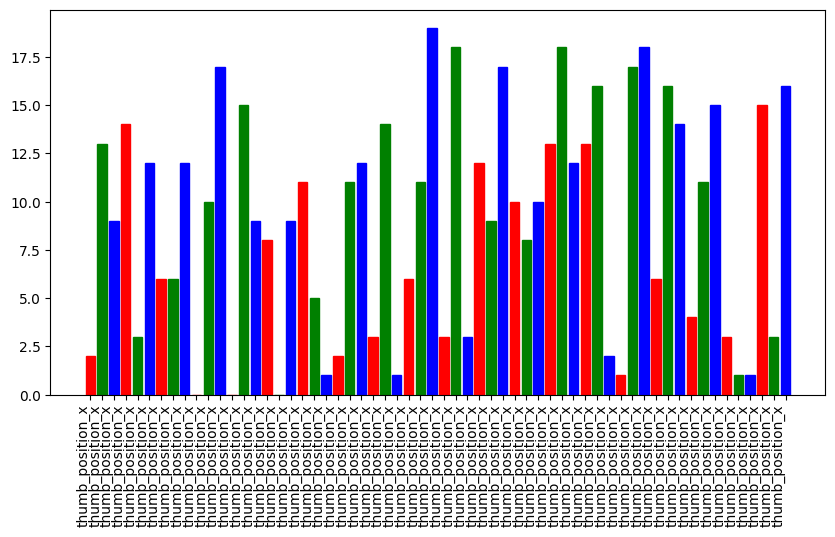

In [13]:

import matplotlib.pyplot as plt
import numpy as np
import os

def plot(dir=None):
    label_names = ['thumb_position_x']*60
    to_plot = np.random.randint(0, 20, size=len(label_names))

    plt.figure(figsize=(10, 5))
    plt.xticks(np.arange(len(label_names)), label_names)
    # rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
    bar = plt.bar(np.arange(len(label_names)), to_plot , align='center', )
    for i in range(0, len(label_names), 3):
        bar[i].set_color('r')
        bar[i+1].set_color('g')
        bar[i+2].set_color('b')
    # set plot size
    plt.savefig(os.path.join(dir,'losses.png'), bbox_inches='tight')
plot('.')